In [ ]:
!pip install scikeras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from pandas import read_csv
from pandas import DataFrame
from statsmodels.graphics.tsaplots import plot_acf

# Stasiun Meteorologi Oesman

## Preprocessing Data

In [ ]:
#Impor data
data_oesman = pd.read_excel('/content/drive/MyDrive/Data/Rata2 SS Stasiun 1.xlsx', sheet_name='Oesman', usecols="B")
data_oesman.head()

,mean_ss
0,5.860000
1,3.685714
2,5.471429
3,4.414286
4,3.814286


In [ ]:
df = pd.DataFrame(data_oesman)
df.isna().sum()

,0
mean_ss,0


In [ ]:
df = pd.DataFrame(data_oesman)
df.fillna(df.mean(), inplace=True)
df.head()

,mean_ss
0,5.860000
1,3.685714
2,5.471429
3,4.414286
4,3.814286


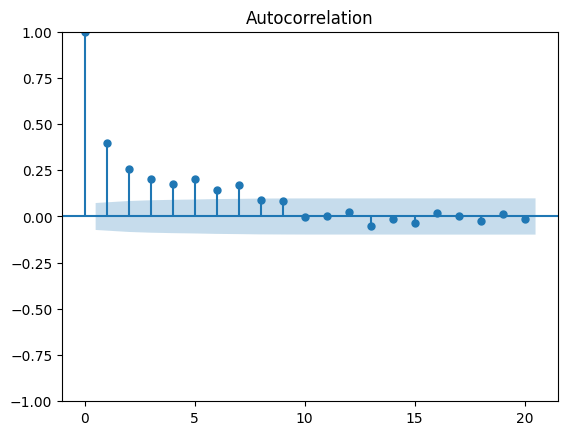

In [ ]:
plot_acf(data_oesman, lags=20)
plt.show()

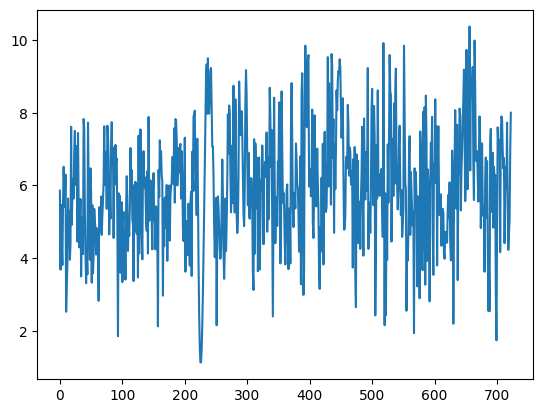

In [ ]:
plt.plot(data_oesman)
plt.show()

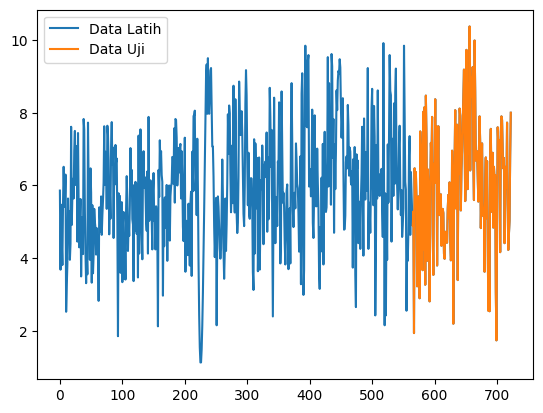

In [ ]:
plt.plot(data_oesman, label='Data Latih')
plt.plot(data_oesman[565:], label='Data Uji')
plt.legend()
plt.show()

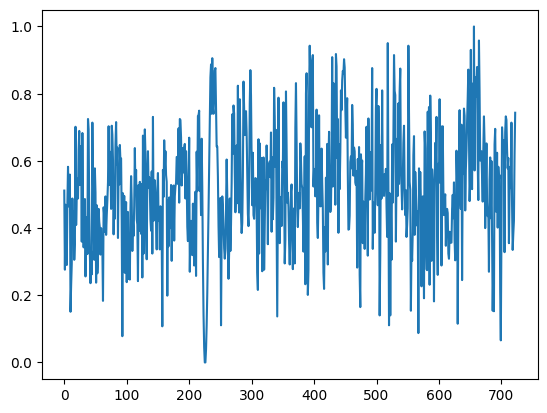

In [ ]:
#Normalisasi Data
scaler = MinMaxScaler(feature_range=(0,1))
data_oesman = scaler.fit_transform(data_oesman)
plt.plot(data_oesman)

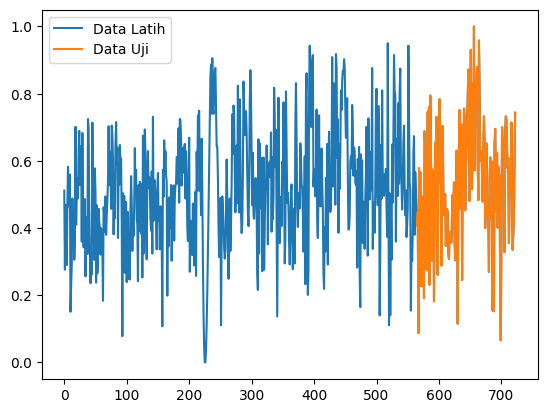

In [ ]:
plt.plot(data_oesman, label='Data Latih')
plt.plot(range(565, len(data_oesman)), data_oesman[565:], label='Data Uji')
plt.legend()
plt.show()

In [ ]:
# Pembagian data
train_size = 565
test_size = len(data_oesman) - train_size
train, test = data_oesman[0:train_size,:], data_oesman[train_size:len(data_oesman),:]

In [ ]:
# Supervised Learning
def create_dataset(dataset, look_back=24):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 24, 1))
testX = np.reshape(testX, (testX.shape[0], 24, 1))
trainX

array([[[0.51157931],
        [0.27618466],
        [0.46951141],
        ...,
        [0.54684211],
        [0.48807077],
        [0.63190587]],

       [[0.27618466],
        [0.46951141],
        [0.35506197],
        ...,
        [0.48807077],
        [0.63190587],
        [0.68913059]],

       [[0.46951141],
        [0.35506197],
        [0.29010419],
        ...,
        [0.63190587],
        [0.68913059],
        [0.52828274]],

       ...,

       [[0.80512664],
        [0.87472427],
        [0.579321  ],
        ...,
        [0.38908748],
        [0.61643973],
        [0.67366445]],

       [[0.87472427],
        [0.579321  ],
        [0.52673612],
        ...,
        [0.61643973],
        [0.67366445],
        [0.3798078 ]],

       [[0.579321  ],
        [0.52673612],
        [0.45559188],
        ...,
        [0.67366445],
        [0.3798078 ],
        [0.56694809]]])

## Model LSTM

In [ ]:
# Mendefinisikan fungsi untuk lstm model

def create_model(learning_rate=0.001, look_back=24, units=64):
    model = Sequential()
    model.add(Input(shape=(look_back, 1)))
    model.add(LSTM(units, return_sequences=True)) # Define input shape using Input layer
    model.add(Dropout(0.2))
    model.add(LSTM(units, return_sequences=True)) # Define input shape using Input layer
    model.add(Dropout(0.1))
    model.add(LSTM(units))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Membentuk model dengan KerasRegressor
model = KerasRegressor(build_fn=create_model, learning_rate=0.001, verbose=2)

In [ ]:
# Hyperparameter tuning
param_grid = {'batch_size': [32, 64, 128],
              'epochs': [50, 100, 150],
              'learning_rate': [0.001, 0.1]}

# GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(trainX, trainY)

# Menampilkan skor terbaik dan parameter terbaik
print('Best Score (Negative MSE):', grid_result.best_score_)
print('Best Params:', grid_result.best_params_)

# Menampilkan hasil untuk setiap kombinasi parameter
results = grid_result.cv_results_
for mean_score, std_score, params in zip(results['mean_test_score'],
                                         results['std_test_score'],
                                         results['params']):
    mean_loss = -mean_score  # Konversi ke loss
    print("Hyperparameters:", params)
    print("Mean Loss:", mean_loss)
    print("Standard Deviation of Score:", std_score)
    print()

In [ ]:
# Membangun dan melatih kembali model dengan hyperparameter terbaik
best_lr = grid_result.best_params_['learning_rate']
best_bs = grid_result.best_params_['batch_size']
best_ep = grid_result.best_params_['epochs']
best_units = 64 # neuron
best_model = create_model(learning_rate=best_lr, units=best_units)
history = best_model.fit(trainX, trainY, epochs=best_ep, batch_size=best_bs,
verbose=2)

Epoch 1/150
17/17 - 6s - 356ms/step - loss: 0.0773
Epoch 2/150
17/17 - 1s - 39ms/step - loss: 0.0359
Epoch 3/150
17/17 - 1s - 72ms/step - loss: 0.0324
Epoch 4/150
17/17 - 1s - 36ms/step - loss: 0.0311
Epoch 5/150
17/17 - 1s - 38ms/step - loss: 0.0305
Epoch 6/150
17/17 - 1s - 38ms/step - loss: 0.0304
Epoch 7/150
17/17 - 1s - 73ms/step - loss: 0.0307
Epoch 8/150
17/17 - 1s - 37ms/step - loss: 0.0302
Epoch 9/150
17/17 - 1s - 38ms/step - loss: 0.0298
Epoch 10/150
17/17 - 2s - 98ms/step - loss: 0.0296
Epoch 11/150
17/17 - 1s - 64ms/step - loss: 0.0296
Epoch 12/150
17/17 - 1s - 64ms/step - loss: 0.0297
Epoch 13/150
17/17 - 1s - 76ms/step - loss: 0.0296
Epoch 14/150
17/17 - 1s - 54ms/step - loss: 0.0287
Epoch 15/150
17/17 - 1s - 59ms/step - loss: 0.0288
Epoch 16/150
17/17 - 1s - 37ms/step - loss: 0.0280
Epoch 17/150
17/17 - 1s - 38ms/step - loss: 0.0280
Epoch 18/150
17/17 - 1s - 37ms/step - loss: 0.0277
Epoch 19/150
17/17 - 1s - 36ms/step - loss: 0.0272
Epoch 20/150
17/17 - 1s - 38ms/step - l

In [ ]:
# Prediksi data uji
predictions = []
for i in range(len(testX)):
 X = testX[i]
 X = np.reshape(X, (1, look_back, 1))
 yhat = best_model.predict(X)
 yhat = scaler.inverse_transform(yhat)
 predictions.append(yhat)
for i in range(len(predictions)):
 expected = scaler.inverse_transform(testY[i].reshape(-1, 1))
 print('Week=%d, Predicted=%f, Expected=%f' % (i+1, predictions[i],
expected))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

<ipython-input-294-76e9005d22a0>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Week=%d, Predicted=%f, Expected=%f' % (i+1, predictions[i],
<ipython-input-294-76e9005d22a0>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Week=%d, Predicted=%f, Expected=%f' % (i+1, predictions[i],
<ipython-input-294-76e9005d22a0>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Week=%d, Predicted=%f, Expected=%f' % (i+1, predictions[i],
<ipython-input-294-

In [ ]:
# Prediksi data latih
predictions_train = []
for i in range(len(trainX)):
 X = trainX[i]
 X = np.reshape(X, (1, look_back, 1))
 yhat = best_model.predict(X)
 yhat = scaler.inverse_transform(yhat)
 predictions_train.append(yhat)
for i in range(len(predictions_train)):
 expected_train = scaler.inverse_transform(trainY[i].reshape(-1, 1))
 print('Week=%d, Predicted=%f, Expected=%f' % (i+1, predictions_train[i],
expected_train))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

<ipython-input-295-dd47a57627ec>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Week=%d, Predicted=%f, Expected=%f' % (i+1, predictions_train[i],
<ipython-input-295-dd47a57627ec>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Week=%d, Predicted=%f, Expected=%f' % (i+1, predictions_train[i],
<ipython-input-295-dd47a57627ec>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Week=%d, Predicted=%f, Expected=%f' % (i+1, predictions_train[i],
<

Week=272, Predicted=6.670881, Expected=4.883322
Week=273, Predicted=6.485000, Expected=5.942857
Week=274, Predicted=6.642033, Expected=8.242857
Week=275, Predicted=7.323339, Expected=9.171033
Week=276, Predicted=7.376963, Expected=8.482768
Week=277, Predicted=6.928005, Expected=6.728571
Week=278, Predicted=6.437649, Expected=5.457143
Week=279, Predicted=6.269764, Expected=6.900000
Week=280, Predicted=6.986659, Expected=5.185714
Week=281, Predicted=6.580321, Expected=5.085714
Week=282, Predicted=6.521204, Expected=5.736128
Week=283, Predicted=6.547599, Expected=6.203343
Week=284, Predicted=6.515797, Expected=6.186744
Week=285, Predicted=6.316392, Expected=5.385714
Week=286, Predicted=5.926625, Expected=3.614286
Week=287, Predicted=5.339486, Expected=3.128571
Week=288, Predicted=5.022202, Expected=7.271429
Week=289, Predicted=6.294022, Expected=4.128571
Week=290, Predicted=5.621445, Expected=7.157143
Week=291, Predicted=6.377631, Expected=6.300000
Week=292, Predicted=6.171279, Expected=5

<ipython-input-295-dd47a57627ec>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Week=%d, Predicted=%f, Expected=%f' % (i+1, predictions_train[i],
<ipython-input-295-dd47a57627ec>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Week=%d, Predicted=%f, Expected=%f' % (i+1, predictions_train[i],
<ipython-input-295-dd47a57627ec>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Week=%d, Predicted=%f, Expected=%f' % (i+1, predictions_train[i],
<

## Evaluasi

RMSE test: 1.5150
MAPE test: 0.2486


<function matplotlib.pyplot.show(close=None, block=None)>

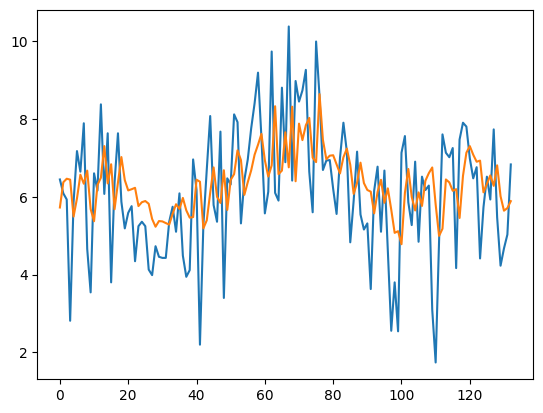

In [ ]:
# Evaluasi
predictions = np.array(predictions)
testY = np.array(testY)
testY = scaler.inverse_transform([testY])
testY = np.array(testY).reshape(-1, 1) # Reshape testY_coba to have 2 dimensions
predictions= np.array(predictions).reshape(-1, 1)
rmse = np.sqrt(mean_squared_error(testY, predictions))
print('RMSE test: %.4f' % rmse)
mape = mean_absolute_percentage_error(testY, predictions)
print('MAPE test: %.4f' % mape)
plt.plot(testY)
plt.plot(predictions)
plt.show


In [ ]:
mapee = np.mean(np.abs((testY - predictions) / testY )) * 100
mapee

24.857155808606315

RMSE test: 1.4227
MAPE test: 0.2372


<function matplotlib.pyplot.show(close=None, block=None)>

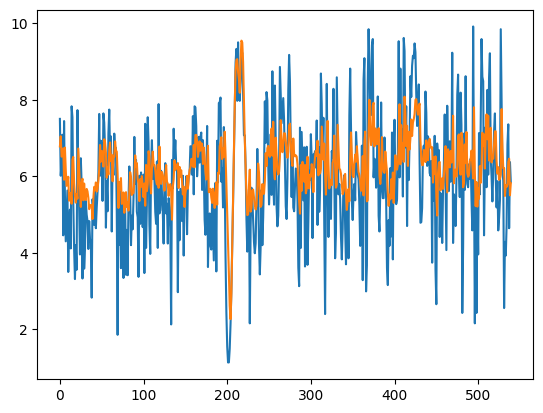

In [ ]:
predictions_train = np.array(predictions_train)
trainY = np.array(trainY)
trainY = scaler.inverse_transform([trainY])
trainY = np.array(trainY).reshape(-1, 1) # Reshape testY_coba to have 2 dimensions
predictions_train = np.array(predictions_train).reshape(-1, 1)
rmse_train = np.sqrt(mean_squared_error(trainY, predictions_train))
print('RMSE test: %.4f' % rmse_train)
mape_train = mean_absolute_percentage_error(trainY, predictions_train)
print('MAPE test: %.4f' % mape_train)
plt.plot(trainY)
plt.plot(predictions_train)
plt.show

## Forecast 12 Periode

In [ ]:
forecast_test = 12  # Forecast 12 periode kedepan
predictions_test = []

# Ambil data terakhir dari data test sebagai input awal
last_data_test = testX[-1].reshape(1,24, 1)

for _ in range(forecast_test):
    # Prediksi nilai berikutnya
    next_value = best_model.predict(last_data_test, verbose=0)
    # Tambahkan prediksi ke dalam list predictions_test
    predictions_test.append(next_value[0, 0])

    # Hapus elemen pertama dari last_data_test dan tambahkan next_value
    last_data_test = np.append(last_data_test[:, 1:, :], next_value.reshape(1, 1, 1), axis=1)

# Cetak hasil prediksi
print("Prediksi (scaled):", predictions_test)

# Inverse transform untuk mendapatkan nilai asli
predictions_test_inverse = scaler.inverse_transform(np.array(predictions_test).reshape(-1, 1))
print("Prediksi (asli):", predictions_test_inverse)


Prediksi (scaled): [0.51440597, 0.54824305, 0.5583401, 0.55235213, 0.54339665, 0.5408521, 0.54761636, 0.5618342, 0.57834333, 0.5914613, 0.59806323, 0.5980513]
Prediksi (asli): [[5.8861094]
 [6.1986547]
 [6.2919188]
 [6.2366095]
 [6.1538897]
 [6.1303864]
 [6.1928663]
 [6.324193 ]
 [6.476684 ]
 [6.5978518]
 [6.658832 ]
 [6.658722 ]]


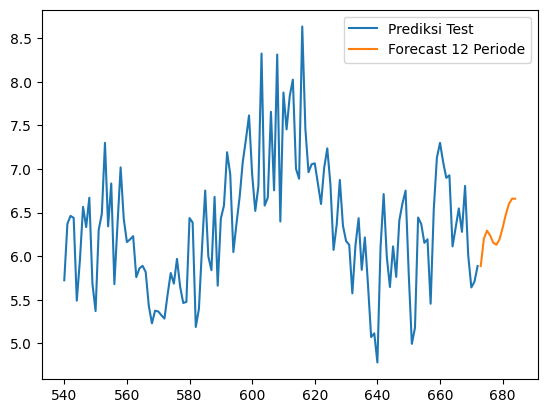

In [ ]:
plt.plot(range(len(predictions_train), len(predictions_train) + len(predictions)), predictions, label='Prediksi Test')
plt.plot(range(len(predictions_train) + len(predictions), len(predictions_train) + len(predictions) + len(predictions_test_inverse)), predictions_test_inverse, label='Forecast 12 Periode')
plt.legend()
plt.show()

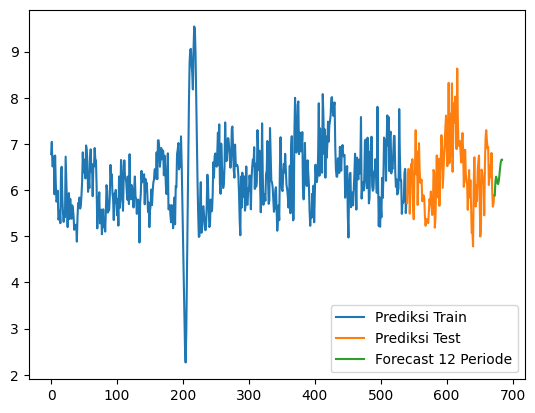

In [ ]:
# Plot baseline dan prediksi

plt.plot(range(len(predictions_train)), predictions_train, label='Prediksi Train')
plt.plot(range(len(predictions_train), len(predictions_train) + len(predictions)), predictions, label='Prediksi Test')
plt.plot(range(len(predictions_train) + len(predictions), len(predictions_train) + len(predictions) + len(predictions_test_inverse)), predictions_test_inverse, label='Forecast 12 Periode')
plt.legend()
plt.show()

## Forecast 24 Periode

In [ ]:
forecast_test = 24 # Forecast 24 periode kedepan
predictions_test = []

# Ambil data terakhir dari data test sebagai input awal
last_data_test = testX[-1].reshape(1,24, 1)

for _ in range(forecast_test):
    # Prediksi nilai berikutnya
    next_value = best_model.predict(last_data_test, verbose=0)
    # Tambahkan prediksi ke dalam list predictions_test
    predictions_test.append(next_value[0, 0])

    # Hapus elemen pertama dari last_data_test dan tambahkan next_value
    last_data_test = np.append(last_data_test[:, 1:, :], next_value.reshape(1, 1, 1), axis=1)

# Cetak hasil prediksi
print("Prediksi (scaled):", predictions_test)

# Inverse transform untuk mendapatkan nilai asli
predictions_test_inverse = scaler.inverse_transform(np.array(predictions_test).reshape(-1, 1))
print("Prediksi (asli):", predictions_test_inverse)

Prediksi (scaled): [0.51440597, 0.54824305, 0.5583401, 0.55235213, 0.54339665, 0.5408521, 0.54761636, 0.5618342, 0.57834333, 0.5914613, 0.59806323, 0.5980513, 0.5943143, 0.590461, 0.58894175, 0.5902344, 0.5934126, 0.59703815, 0.59967864, 0.6008791, 0.60086066, 0.6004053, 0.60050136, 0.6014532]
Prediksi (asli): [[5.8861094]
 [6.1986547]
 [6.2919188]
 [6.2366095]
 [6.1538897]
 [6.1303864]
 [6.1928663]
 [6.324193 ]
 [6.476684 ]
 [6.5978518]
 [6.658832 ]
 [6.658722 ]
 [6.624204 ]
 [6.588612 ]
 [6.5745792]
 [6.5865192]
 [6.6158752]
 [6.649364 ]
 [6.6737533]
 [6.6848416]
 [6.6846714]
 [6.680465 ]
 [6.6813526]
 [6.6901445]]


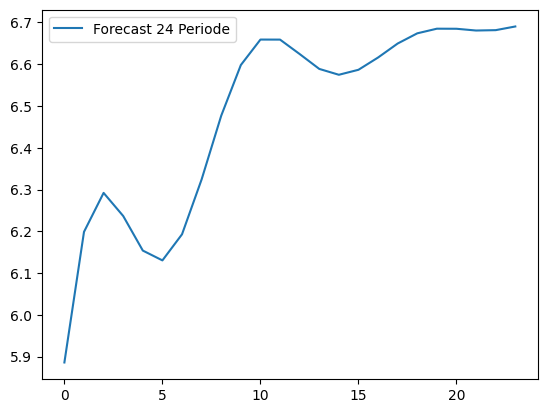

In [ ]:
plt.plot(predictions_test_inverse, label='Forecast 24 Periode')
plt.legend()
plt.show()

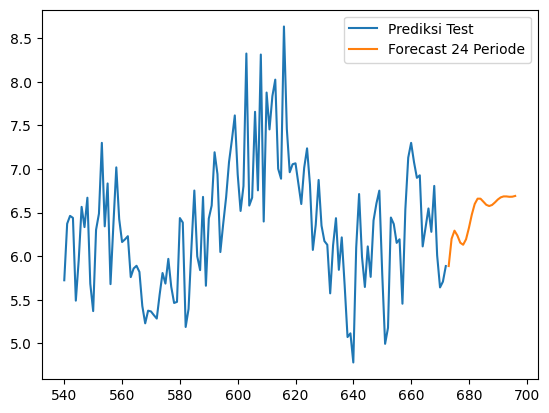

In [ ]:
plt.plot(range(len(predictions_train), len(predictions_train) + len(predictions)), predictions, label='Prediksi Test')
plt.plot(range(len(predictions_train) + len(predictions), len(predictions_train) + len(predictions) + len(predictions_test_inverse)), predictions_test_inverse, label='Forecast 24 Periode')
plt.legend()
plt.show()

In [ ]:
len(predictions_test_inverse)

24

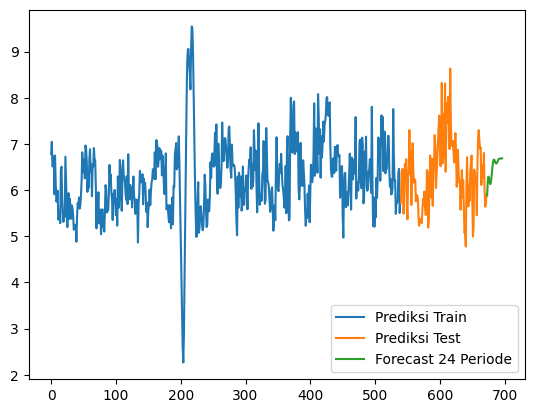

In [ ]:
# Plot baseline dan prediksi LSMT
plt.plot(range(len(predictions_train)), predictions_train, label='Prediksi Train')
plt.plot(range(len(predictions_train), len(predictions_train) + len(predictions)), predictions, label='Prediksi Test')
plt.plot(range(len(predictions_train) + len(predictions), len(predictions_train) + len(predictions) + len(predictions_test_inverse)), predictions_test_inverse, label='Forecast 24 Periode')
plt.legend()
plt.show()

# Plot

Data aktual dan data dugaan yang telah diperoleh, baik dengan metode ARIMA maupun LSTM, divisualisasikan dengan line chart.

## Data Oesman sesudah interpolasi

In [ ]:
data_oesman_asli = pd.read_excel('/content/Rata2 dorr.xlsx', sheet_name='Oesman', usecols = 'B:D' )
data_oesman_asli

,mean_ss,Week,Year
0,5.860000,1,NaN
1,3.685714,2,NaN
2,5.471429,3,NaN
3,4.414286,4,NaN
4,3.814286,5,NaN
...,...,...,...
718,5.300000,43,NaN
719,4.328571,44,NaN
720,5.057143,45,NaN
721,7.585714,46,NaN


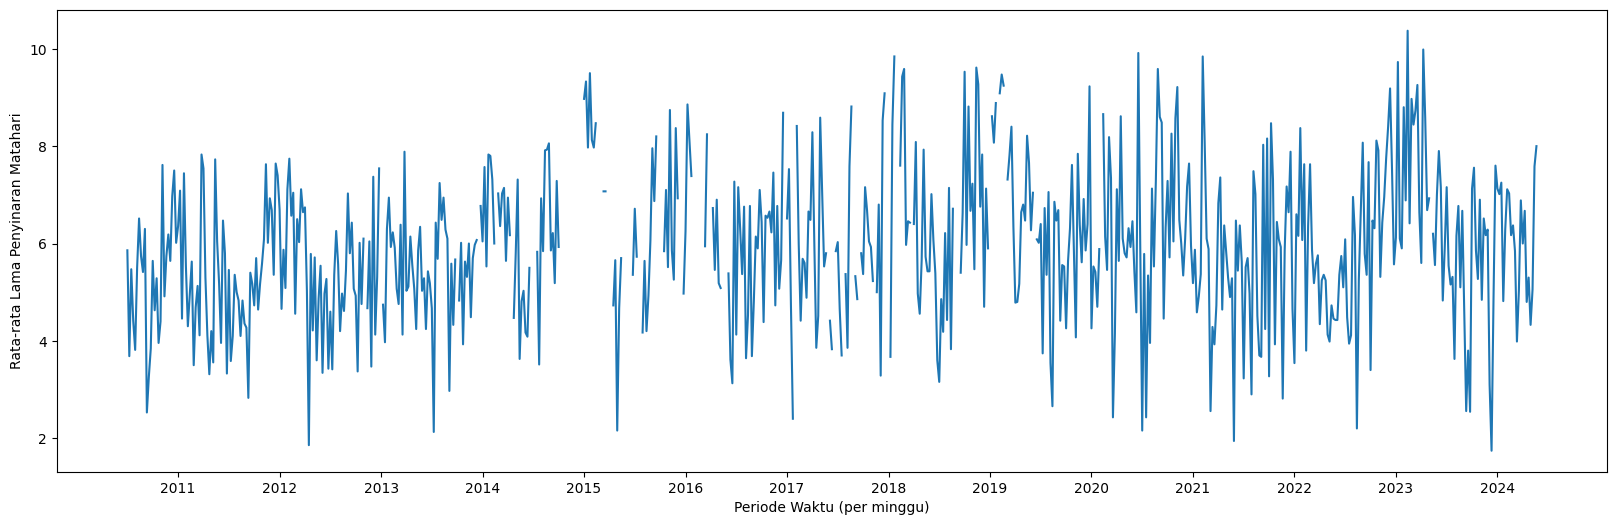

In [ ]:
# Visualisasi Data Deret Waktu pada SM Oesman (sebelum interpolasi)
custom_ticks = {26: '2011', 78: '2012', 130: '2013', 182: '2014', 234: '2015', 286: '2016', 338: '2017', 390: '2018', 442: '2019', 494: '2020', 546: '2021', 598: '2022', 650: '2023', 702: '2024'}  # Label custom
labels = [custom_ticks[i] if i in custom_ticks else '' for i in data_oesman_asli['mean_ss']]

plt.figure(figsize=(20, 6))
plt.plot(data_oesman_asli['mean_ss'])
plt.ylabel("Rata-rata Lama Penyinaran Matahari")
plt.xlabel("Periode Waktu (per minggu)")
plt.xticks(ticks=list(custom_ticks.keys()), labels=list(custom_ticks.values()))
plt.show()

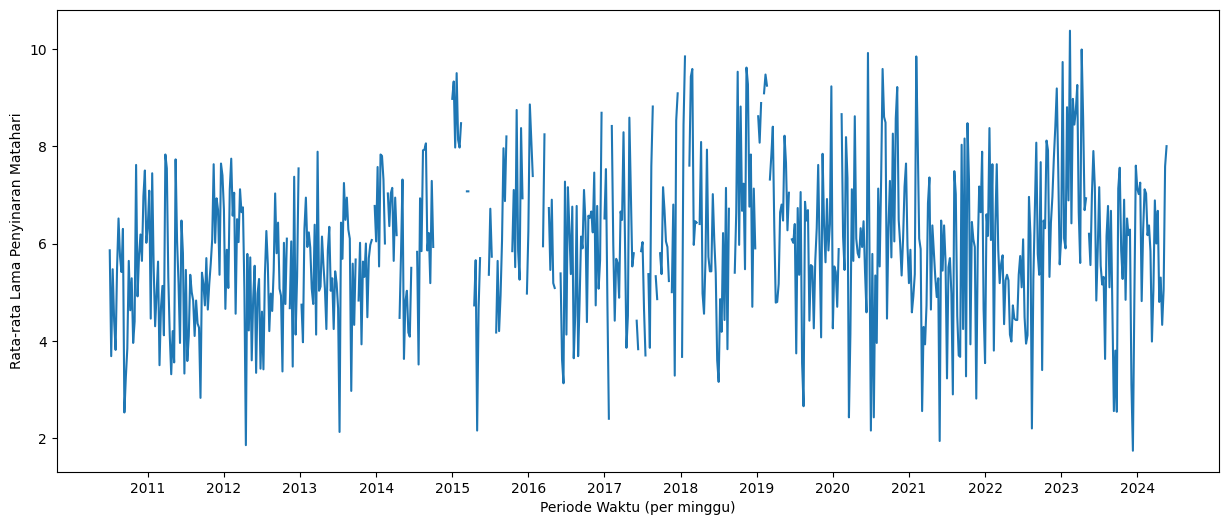

In [ ]:
# Visualisasi Data Deret Waktu pada SM Oesman (sebelum interpolasi)
custom_ticks = {26: '2011', 78: '2012', 130: '2013', 182: '2014', 234: '2015', 286: '2016', 338: '2017', 390: '2018', 442: '2019', 494: '2020', 546: '2021', 598: '2022', 650: '2023', 702: '2024'}  # Label custom
labels = [custom_ticks[i] if i in custom_ticks else '' for i in data_oesman_asli['mean_ss']]

plt.figure(figsize=(15, 6))
plt.plot(data_oesman_asli['mean_ss'])
plt.ylabel("Rata-rata Lama Penyinaran Matahari")
plt.xlabel("Periode Waktu (per minggu)")
plt.xticks(ticks=list(custom_ticks.keys()), labels=list(custom_ticks.values()))
plt.show()

## Data Oesman setelah interpolasi

In [ ]:
data_oesman = pd.read_excel('/content/drive/MyDrive/Data/Rata2 SS Stasiun 1.xlsx', sheet_name='Oesman', usecols="B")
data_oesman.head()

,mean_ss
0,5.860000
1,3.685714
2,5.471429
3,4.414286
4,3.814286


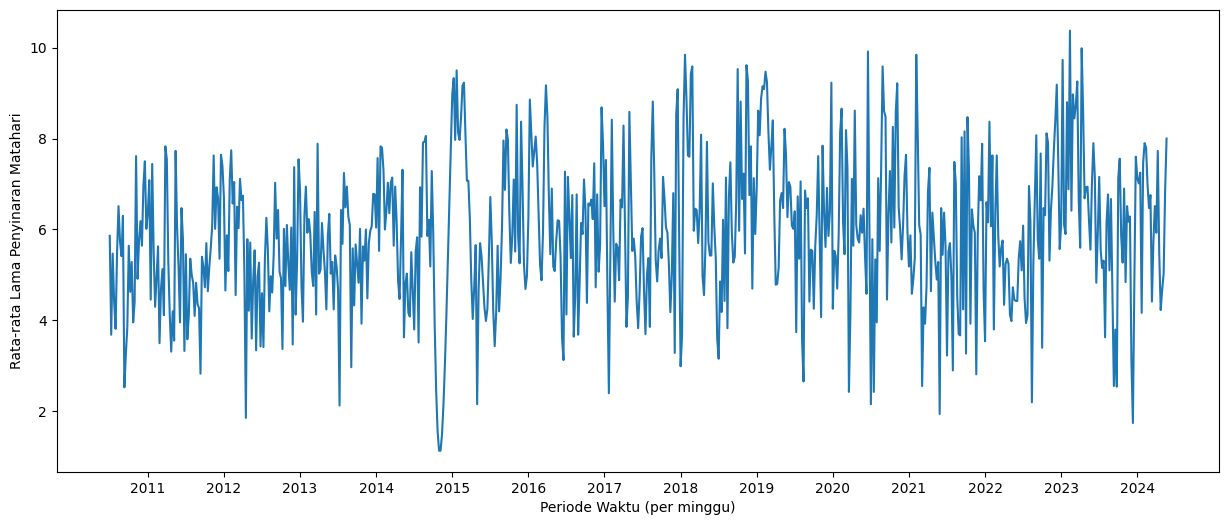

In [ ]:
# Visualisasi Data Deret Waktu pada SM Oesman (setelah interpolasi)

custom_ticks = {26: '2011', 78: '2012', 130: '2013', 182: '2014', 234: '2015', 286: '2016', 338: '2017', 390: '2018', 442: '2019', 494: '2020', 546: '2021', 598: '2022', 650: '2023', 702: '2024'}  # Label custom
labels = [custom_ticks[i] if i in custom_ticks else '' for i in data_oesman]

plt.figure(figsize=(15, 6))
plt.plot(data_oesman)
plt.ylabel("Rata-rata Lama Penyinaran Matahari")
plt.xlabel("Periode Waktu (per minggu)")
plt.xticks(ticks=list(custom_ticks.keys()), labels=list(custom_ticks.values()))
plt.show()

## Pembagian data

In [ ]:
train_size = 565

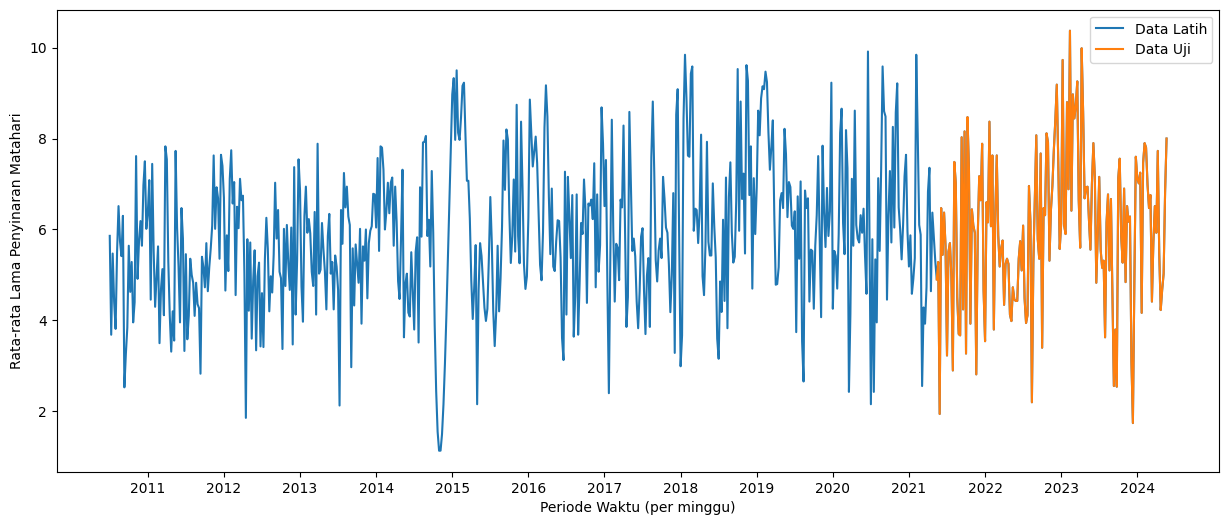

In [ ]:
# Visualisasi pembaguan data deret waktu

custom_ticks = {26: '2011', 78: '2012', 130: '2013', 182: '2014', 234: '2015', 286: '2016', 338: '2017', 390: '2018', 442: '2019', 494: '2020', 546: '2021', 598: '2022', 650: '2023', 702: '2024'}  # Label custom
labels = [custom_ticks[i] if i in custom_ticks else '' for i in data_oesman]

plt.figure(figsize=(15, 6))
plt.plot(data_oesman, label='Data Latih')
plt.plot(data_oesman[565:], label='Data Uji')
plt.ylabel("Rata-rata Lama Penyinaran Matahari")
plt.xlabel("Periode Waktu (per minggu)")
plt.xticks(ticks=list(custom_ticks.keys()), labels=list(custom_ticks.values()))
plt.legend()
plt.show()

Normalisasi Data

In [ ]:
#Normalisasi Data
scaler = MinMaxScaler(feature_range=(0,1))
data_oesman = scaler.fit_transform(data_oesman)

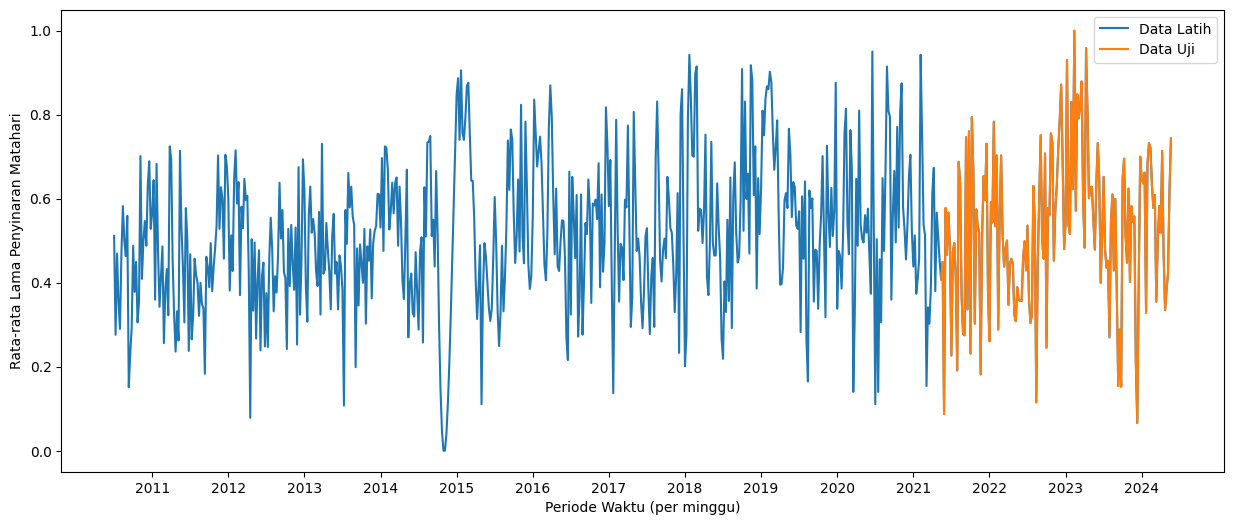

In [ ]:
# Visualisasi data yang telah dinormalisasikan

custom_ticks = {26: '2011', 78: '2012', 130: '2013', 182: '2014', 234: '2015', 286: '2016', 338: '2017', 390: '2018', 442: '2019', 494: '2020', 546: '2021', 598: '2022', 650: '2023', 702: '2024'}  # Label custom
labels = [custom_ticks[i] if i in custom_ticks else '' for i in range(len(data_oesman))]

plt.figure(figsize=(15, 6))
plt.plot(data_oesman, label='Data Latih')
plt.plot(range(565, len(data_oesman)), data_oesman[565:], label='Data Uji')
plt.ylabel("Rata-rata Lama Penyinaran Matahari")
plt.xlabel("Periode Waktu (per minggu)")
plt.xticks(ticks=list(custom_ticks.keys()), labels=list(custom_ticks.values()))
plt.legend()
plt.show()

## Arima train (aktual dan dugaan)

In [ ]:
arima_train = pd.read_excel('/content/arima_train.xlsx')
arima_train

,train.ts,model101.fitted
0,5.860000,5.877484
1,3.685714,5.843957
2,5.471429,5.067775
3,4.414286,5.448794
4,3.814286,5.200887
...,...,...
560,7.357143,5.949285
561,4.642857,6.436427
562,6.371429,5.628550
563,5.842857,5.969104


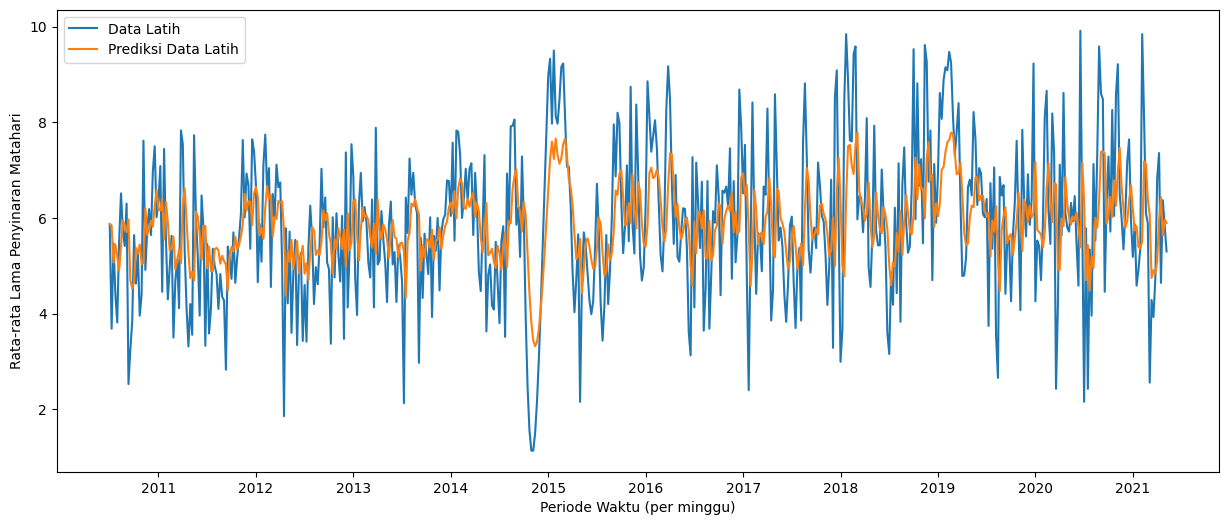

In [ ]:
# Visualisasi data aktual dan data dugaan dengan metode arima untuk data train

custom_ticks = {26: '2011', 78: '2012', 130: '2013', 182: '2014', 234: '2015', 286: '2016', 338: '2017', 390: '2018', 442: '2019', 494: '2020', 546: '2021'}  # Label custom
labels = [custom_ticks[i] if i in custom_ticks else '' for i in arima_train['train.ts']]

plt.figure(figsize=(15, 6))
plt.plot(arima_train['train.ts'], label='Data Latih')
plt.plot(arima_train['model101.fitted'], label='Prediksi Data Latih')
plt.ylabel("Rata-rata Lama Penyinaran Matahari")
plt.xlabel("Periode Waktu (per minggu)")
plt.xticks(ticks=list(custom_ticks.keys()), labels=list(custom_ticks.values()))
plt.legend()
plt.show()

## Arima test (aktual dan dugaan)

In [ ]:
arima_test = pd.read_excel('/content/arima_test.xlsx')
arima_test

,test.ts,hasil.1.158.
0,4.900000,5.677052
1,5.285714,5.735826
2,1.942857,5.777548
3,6.471429,5.807166
4,5.442857,5.828192
...,...,...
153,4.228571,5.879639
154,4.671429,5.879639
155,5.028571,5.879639
156,6.828571,5.879639


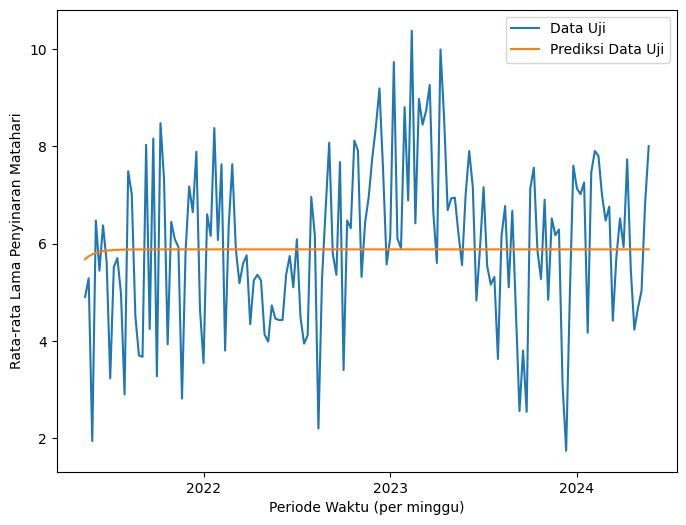

In [ ]:
# Visualisasi data aktual dan data dugaan dengan metode arima untuk data test

custom_ticks =  {598-565: '2022', 650-565: '2023', 702-565: '2024'}
labels = [custom_ticks[i] if i in custom_ticks else '' for i in arima_test['test.ts']]

plt.figure(figsize=(8, 6))

plt.plot(arima_test['test.ts'], label='Data Uji')
plt.plot(arima_test['hasil.1.158.'], label='Prediksi Data Uji')
plt.ylabel("Rata-rata Lama Penyinaran Matahari")
plt.xlabel("Periode Waktu (per minggu)")
plt.xticks(ticks=list(custom_ticks.keys()), labels=list(custom_ticks.values()))
plt.legend()
plt.show()

## LSTM train (aktual dan dugaan)

In [ ]:
lstm_train = pd.read_excel('/content/lstm_train.xlsx')
lstm_train

,trainY,predictions_train
0,7.500000,6.779587
1,6.014286,7.045758
2,6.357143,6.513188
3,7.085714,6.533316
4,4.457143,6.728794
...,...,...
535,6.828571,5.784178
536,7.357143,6.376821
537,4.642857,6.460111
538,6.371429,5.503325


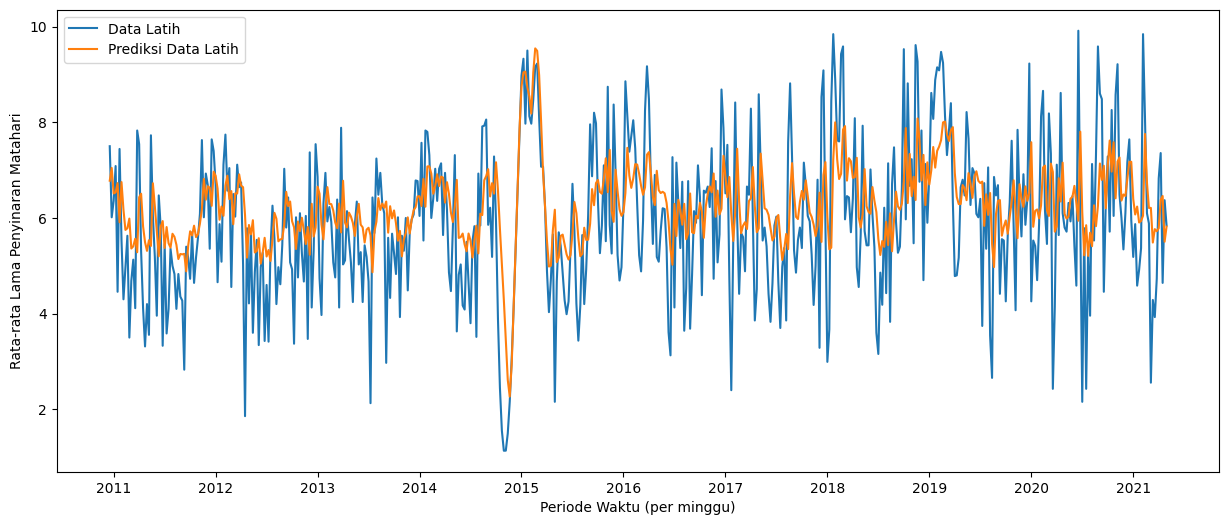

In [ ]:
# Visualisasi data aktual dan data dugaan dengan metode lstm untuk data train

custom_ticks = {26-24: '2011', 78-24: '2012', 130-24: '2013', 182-24: '2014', 234-24: '2015', 286-24: '2016', 338-24: '2017', 390-24: '2018', 442-24: '2019', 494-24: '2020', 546-24: '2021'}  # Label custom
labels = [custom_ticks[i] if i in custom_ticks else '' for i in lstm_train['trainY']]

plt.figure(figsize=(15, 6))

plt.plot(lstm_train['trainY'], label='Data Latih')
plt.plot(lstm_train['predictions_train'], label='Prediksi Data Latih')
plt.ylabel("Rata-rata Lama Penyinaran Matahari")
plt.xlabel("Periode Waktu (per minggu)")
plt.xticks(ticks=list(custom_ticks.keys()), labels=list(custom_ticks.values()))
plt.legend()
plt.show()

## LSTM test (aktual dan dugaan)

In [ ]:
lstm_test = pd.read_excel('/content/lstm_test.xlsx')
lstm_test

,testY,predictions
0,6.442857,5.722919
1,6.085714,6.371500
2,5.928571,6.461627
3,2.814286,6.438540
4,5.857143,5.489394
...,...,...
128,5.471429,6.805271
129,4.228571,6.010052
130,4.671429,5.641091
131,5.028571,5.707454


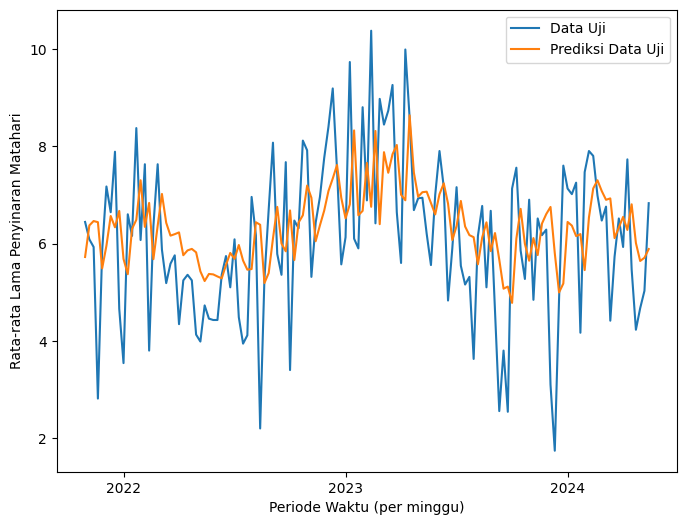

In [ ]:
# Visualisasi data aktual dan data dugaan dengan metode lstm untuk data test

custom_ticks =  {598-565-24: '2022', 650-565-24: '2023', 702-565-24: '2024'}
labels = [custom_ticks[i] if i in custom_ticks else '' for i in lstm_test['testY']]

plt.figure(figsize=(8, 6))


plt.plot(lstm_test['testY'], label='Data Uji')
plt.plot(lstm_test['predictions'], label='Prediksi Data Uji')
plt.ylabel("Rata-rata Lama Penyinaran Matahari")
plt.xlabel("Periode Waktu (per minggu)")
plt.xticks(ticks=list(custom_ticks.keys()), labels=list(custom_ticks.values()))
plt.legend()
plt.show()

## Peramalan

In [ ]:
df_forecast = pd.read_excel('/content/df_forecast.xlsx')
df_forecast

,predictions_test_inverse,predictions_arima
0,5.886109,5.879639
1,6.198655,5.879639
2,6.291919,5.879639
3,6.236609,5.879639
4,6.153890,5.879639
5,6.130386,5.879639
6,6.192866,5.879639
7,6.324193,5.879639
8,6.476684,5.879639
9,6.597852,5.879639


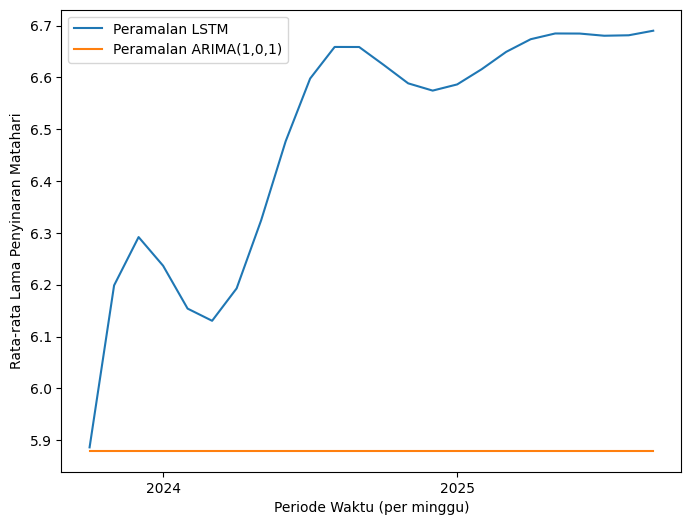

In [ ]:
# Visualisasi data hasil peramalan dengan metode arima dan lstm

custom_ticks =  {3:'2024', 15:'2025'}
labels = [custom_ticks[i] if i in custom_ticks else '' for i in df_forecast['predictions_test_inverse']]

plt.figure(figsize=(8, 6))


plt.plot(df_forecast['predictions_test_inverse'], label='Peramalan LSTM')
plt.plot(df_forecast['predictions_arima'], label='Peramalan ARIMA(1,0,1)')
plt.ylabel("Rata-rata Lama Penyinaran Matahari")
plt.xlabel("Periode Waktu (per minggu)")
plt.xticks(ticks=list(custom_ticks.keys()), labels=list(custom_ticks.values()))
plt.legend()
plt.show()